# Chapter 2d: Classification

## 1. Logistic regression

Logistic regression is a machine learning method for predicting binary classes. The outcome or target variable $y$ is dichotomous in nature. Dichotomous means there are only two possible classes. For example, we will later consider the case: are there aftershocks (yes/no) at a given location $(lon,lat)$ after a large earthquake? Logistic Regression predicts the probability of occurrence of a binary event utilizing a logit (or sigmoid) function:
$$
P(y) = \frac{1}{1 + e^{-y}}
$$
where the input is a linear regression $y = w_0 + w_1 x_1 + w_2 x_2 + \cdots$ (see the previous lecture on linear regression). To illustrate the difference between linear regression and logistic regression, we will first define an ad hoc data set.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')

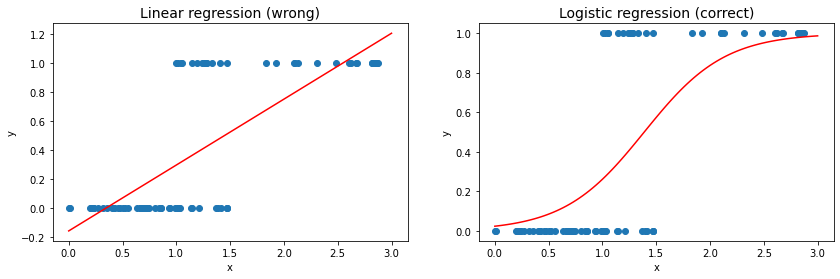

In [2]:
rng = np.random.RandomState()
x = np.concatenate([rng.uniform(0, 1.5, 50), rng.uniform(1, 3, 30)])
y = np.concatenate([np.repeat(0, 50), np.repeat(1, 30)])

linreg_model = LinearRegression(fit_intercept = True)
linreg_model.fit(x[:, np.newaxis], y)

logreg_model = LogisticRegression()
logreg_model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 3, 100)

fig, axs = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(14)

axs[0].scatter(x, y)
axs[0].plot(xfit, linreg_model.predict(xfit[:, np.newaxis]), 'r')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('Linear regression (wrong)', size=14)

axs[1].scatter(x, y)
axs[1].plot(xfit, logreg_model.predict_proba(xfit[:, np.newaxis])[:, 1], 'r')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_title('Logistic regression (correct)', size=14);

We easily notice why a linear regression should not be used on a binary classification problem. First, recall from the previous section that linear regression assumes gaussian noise, which is not the case, but Bernoulli here. Second a linear regression with provide estimates outside the two only values that $y$ can take. In contrast, the logistic regression provides a probabilistic result $0 \le P(y) \le 1$.

## 2. An application to aftershock location prediction

We will now take as geoscience example the recent debate around classification of aftershocks in space. An article published in Nature in 2018 proposed a complex deep neural network as classifier (de Vries et al., 2018). One year later, Mignan & Broccardo (2019) proved, in the same journal, that a logistic regression can provide a similar performance score, if not a better one. Since this has been a highly mediatised study, let us reproduce here the logistic regression model. We will reproduce the deep learning model in a future chapter.

<img src="figs_notebook/fig_Mignan&Broccardo_Nature.png" width = 500>

### 2.1. Data preparation

#### 2.1.1. Data loading

First, we will import the input data defined by de Vries et al. (2018), which consists of the characteristics of 199 mainshocks and the matching $(x,y,z)$ grid points providing 12 stress features and the label $y$ ($y = 1$ if there is at least one aftershock in the grid cell, $y=0$ otherwise). Note that the stress metrics were computed by the authors for each matching mainshock.

The first question will be: Can we predict the location of aftershocks based on stress data? In a second stage, we will investigate if we could use simpler features.

First, download the labelled data from de Vries et al. (2018) available at: https://owncloud.sustech.edu.cn/s/faqetGF3d9KtoKk (WARNING: 1.7 GB once unzipped) - Keep the folder name `AllCSV` and place it in the folder `data/aftershock/` located in the notebook directory. Add also `Training_FileNames.h5` and `Testing_FileNames.h5` provided on BlackBoard.

In [3]:
import fnmatch
import os
import h5py

In [4]:
# import xyz grid features X and label y
notebook_path = os.path.abspath("chap2d.ipynb")
directory = os.path.join(os.path.dirname(notebook_path), "data/aftershocks/AllCSV/")
file_list = os.listdir(directory)
n_files = len(file_list)
file_list.sort()    # will sort files per mainshock date

In [5]:
indata = []
for i in range(len(file_list)):
    mainshock_name = 's' + file_list[i][0:file_list[i].find('_')]
    df_tmp = pd.read_csv(directory + file_list[i])
    df_tmp['ID'] = np.repeat(mainshock_name, len(df_tmp))  #add ID = SRCMOD EventTAG
    indata.append(df_tmp)

data_xyz = pd.concat(indata)
len(data_xyz)

6121210

In [6]:
data_xyz

,x,y,z,stresses_full_xx,stresses_full_xy,stresses_full_yy,stresses_full_xz,stresses_full_yz,stresses_full_zz,stresses_full_max_shear,stresses_full_cfs_1,stresses_full_cfs_2,stresses_full_cfs_3,stresses_full_cfs_4,von_mises,aftershocksyn,ID
0,228050.836661,3.438285e+06,-2500.0,-2643.095958,-303.314853,-8306.190130,-62.011213,-591.513951,-23.523893,4191.904227,1278.439670,-1609.139444,1609.139444,-1278.439670,7423.266049,0.0,s1968HYUGAx01YAGI
1,233050.836661,3.438285e+06,-2500.0,-2506.143012,33.487142,-8293.837540,-40.272330,-619.872533,-25.140746,4180.998624,1353.632905,-1706.330567,1706.330567,-1353.632905,7427.854270,0.0,s1968HYUGAx01YAGI
2,238050.836661,3.438285e+06,-2500.0,-2390.411001,381.016088,-8149.157556,-16.212656,-642.672511,-26.597214,4124.540863,1417.713571,-1789.742291,1789.742291,-1417.713571,7351.107005,0.0,s1968HYUGAx01YAGI
3,243050.836661,3.438285e+06,-2500.0,-2299.362270,723.248609,-7868.650242,9.526966,-659.035520,-27.846052,4021.524131,1466.875844,-1854.619572,1854.619572,-1466.875844,7190.271468,0.0,s1968HYUGAx01YAGI
4,248050.836661,3.438285e+06,-2500.0,-2233.960345,1043.357897,-7454.950559,36.174998,-668.289344,-28.844615,3872.648486,1497.602675,-1896.565287,1896.565287,-1497.602675,6945.768984,0.0,s1968HYUGAx01YAGI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19285,471380.946671,3.728423e+05,-47500.0,710.070096,-5251.054285,20733.987163,3930.203536,-13850.221996,6977.127223,16310.109019,417.800762,18473.143597,-18473.143597,-417.800762,31926.296190,0.0,s2012SUMATR03HAYE
19286,476380.946671,3.728423e+05,-47500.0,-164.919780,-3727.184738,21334.860100,3037.909222,-14138.938807,7085.178929,16380.178960,2239.826880,17679.774101,-17679.774101,-2239.826880,32062.752645,0.0,s2012SUMATR03HAYE
19287,481380.946671,3.728423e+05,-47500.0,-890.077876,-2014.391626,21532.007086,2048.836758,-14190.819417,7084.631269,16293.859627,4189.875411,16435.664962,-16435.664962,-4189.875411,31881.669627,0.0,s2012SUMATR03HAYE
19288,486380.946671,3.728423e+05,-47500.0,-1420.487894,-172.251740,21270.116357,995.878922,-13978.127096,6964.239908,16053.195403,6190.300322,14749.045895,-14749.045895,-6190.300322,31371.023080,0.0,s2012SUMATR03HAYE


In [7]:
# grid coordinates, features X, label y, mainshock ID
data_xyz.columns

Index(['x', 'y', 'z', 'stresses_full_xx', 'stresses_full_xy',
       'stresses_full_yy', 'stresses_full_xz', 'stresses_full_yz',
       'stresses_full_zz', 'stresses_full_max_shear', 'stresses_full_cfs_1',
       'stresses_full_cfs_2', 'stresses_full_cfs_3', 'stresses_full_cfs_4',
       'von_mises', 'aftershocksyn', 'ID'],
      dtype='object')

#### 2.1.2. Data filtering

We now need to filter the data.

In [8]:
data_xyz_1s = data_xyz.loc[data_xyz['aftershocksyn'] == 1]
data_xyz_0s = data_xyz.loc[data_xyz['aftershocksyn'] == 0]
numberOf0s = len(data_xyz_0s)
numberOf1s = len(data_xyz_1s)
[numberOf0s, numberOf1s, numberOf0s/(numberOf0s+numberOf1s)]

[6019888, 101322, 0.9834473903035511]

**EXERCISE 1:** What can you say of the data? What do the 3 values given above mean?

_YOUR ANSWER HERE_

The data is unbalanced towards 0s with most cells empty. This is problematic since the model "no aftershock ever" would give a high accuracy of 98%, which is however useless.

**EXERCISE 2:** Prove that the code below solves the problem.

In [9]:
random_subsample0 = np.random.choice(numberOf0s, numberOf1s)
#random.choice(a, size) samples size elements from np.arange(a)
data_xyz_0s = data_xyz_0s.iloc[random_subsample0]
data_xyz_balanced = data_xyz_1s.append(data_xyz_0s)

# YOUR CODE HERE (to print the result)
#[?, ?]

# SOLUTION
[len(data_xyz_1s), len(data_xyz_0s)]

[101322, 101322]

We need to further split the new data into traning and test sets. For this, we will use the same mainshock ID split as done in de Vries et al. (2018) and Mignan & Broccardo (2019) (as given in the files `Training_FileNames.h5` and `Testing_FileNames.h5`).

In [10]:
# data split
h5file1 = h5py.File(os.path.join(os.path.dirname(notebook_path), "data/aftershocks/Training_FileNames.h5"))
training_filenames = np.array(h5file1.get('file_names_training'))
h5file2 = h5py.File(os.path.join(os.path.dirname(notebook_path), "data/aftershocks/Testing_FileNames.h5"))
testing_filenames = np.array(h5file2.get('file_names_testing'))
[len(training_filenames), len(testing_filenames)]

[142, 57]

In [11]:
training_IDs_temp = map(lambda x: str(x, 'utf-8'), training_filenames)         #from byte to string
training_IDs = list(map(lambda x: 's' + x[0:x.find('_')], training_IDs_temp))  #extract event tag only
testing_IDs_temp = map(lambda x: str(x, 'utf-8'), testing_filenames)           #from byte to string
testing_IDs = list(map(lambda x: 's' + x[0:x.find('_')], testing_IDs_temp))    #extract event tag only

TrainingSet = data_xyz_balanced.loc[data_xyz_balanced['ID'].isin(training_IDs)]
TestingSet = data_xyz_balanced.loc[data_xyz_balanced['ID'].isin(testing_IDs)]

TrainingSet= shuffle(TrainingSet)

[len(TrainingSet), len(TestingSet)]

[164359, 38285]

### 2.2. Logistic regression model

Let us now make a logistic regression using only one metric, the von Mises criterion which was found by de Vries et al. (2018) to be a good predictor. Note that we use the log as normalisation (range of original values very high).

In [13]:
x_train = np.log(TrainingSet['von_mises']).values.reshape(-1,1)
y_train = TrainingSet['aftershocksyn'].values.reshape(-1,1)

**EXERCISE 3:** What did we just do with `reshape(-1,1)`? Explain using `.shape`. Reshaping an array will be common practice in the next chapters, especially when dealing with neural networks. In this simple case, we could have used `TrainingSet['von_mises'].values[:,np.newaxis]` instead.

In [16]:
# YOUR CODE HERE
#print(...)
#print(...)

# SOLUTION
print(TrainingSet['von_mises'].values.shape)
print(TrainingSet['von_mises'].values.reshape(-1,1).shape)

(164359,)
(164359, 1)


**EXERCISE 4:** Create, fit and plot the logistic regression model for the von Mises criterion (as we learned in section 1). To determine the x-axis range, you may check `[np.min(x_train), np.max(x_train)]`.

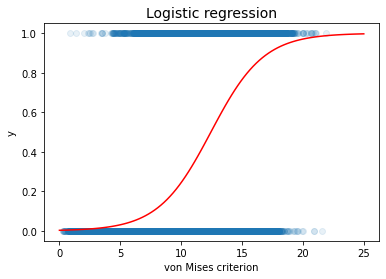

In [17]:
# YOUR CODE HERE
#logreg_model = ?
# ...


# SOLUTION
logreg_model = LogisticRegression()
logreg_model.fit(x_train, y_train)

#[np.min(x_train), np.max(x_train)]
xfit = np.linspace(0, 25, 100)
yfit = logreg_model.predict_proba(xfit[:, np.newaxis])[:, 1]
plt.scatter(x_train, y_train, alpha = .1)
plt.plot(xfit, yfit, 'r')
plt.xlabel('von Mises criterion')
plt.ylabel('y')
plt.title('Logistic regression', size = 14);

We then predict $P(y)$ and the matching $\hat{y}$ with the functions `predict_proba` and `predict`.

**EXERCISE 5:** Based on the model parameter estimates `coef_` and `intercept_`, write down the full equation of the logistic regression model by using Latex notation. The von Mises parameter is written as $\sqrt{3 \Delta J_2}$ in DeVries et al. (2018) (in which $\Delta J_2$ is the second invariant of the deviatoric stress-change tensor).

In [18]:
x_test = np.log(TestingSet['von_mises']).values.reshape(-1,1)
y_test_true = TestingSet['aftershocksyn'].values.reshape(-1,1)

y_pred = logreg_model.predict(x_test)
y_pred_pr = logreg_model.predict_proba(x_test)[:, 1]

print(logreg_model.coef_, logreg_model.intercept_)

[[0.4624318]] [-5.75333636]


_YOUR ANSWER HERE_
$$
...
$$


SOLUTION
$$
P(y) = \frac{1}{1 + e^{-(-5.72589569 + 0.46030139 \ln \sqrt{3 \Delta J_2})}}
$$

### 2.3. Confusion matrix & performance metrics for binary classification

The performance of classifiers can be visualised in a __confusion matrix__, a table layout that allows visualising the performance of the predictive model. Each row of the matrix represents the instances in a predicted class, while each column represents the instances in an actual class (or vice versa). The name stems from the fact that it makes it easy to see whether the model is confusing two classes.

**EXERCISE 6:** Generate the confusion matrix of the previous model by using `plot_confusion_matrix(estimator, X, y_true, cmap='viridis')`. Try different `cmap` options, e.g. `plt.cm.Blues` or others: `['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']`.

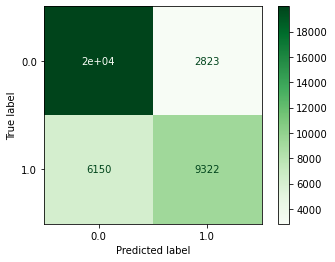

In [19]:
# YOUR CODE HERE



# SOLUTION
plot_confusion_matrix(logreg_model, x_test, y_test_true, cmap = plt.cm.Greens);

The confusion matrix provides the true positives, true negatives, false positives and false negatives from which various scores can be calculated, as shown below:

In [20]:
print(classification_report(y_test_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.88      0.82     22813
         1.0       0.77      0.60      0.68     15472

    accuracy                           0.77     38285
   macro avg       0.77      0.74      0.75     38285
weighted avg       0.77      0.77      0.76     38285



**EXERCISE 7:** Calculate accuracy, precision, recall and F1-score manually (for targer $y=1$). Verify that you obtain the same results as shown above.

Those metrics are defined as follows:

* Accuracy: $ACC = \frac{TP+TN}{TP+TN+FP+FN}$
* Precision (or Positive Prediction Value): $PPV = \frac{TP}{TP+FP}$
* Recall (or True Positive Rate): $TPR = \frac{TP}{TP+FN}$
* F1-score: $F_1 = 2 \frac{PPV \times TPR}{PPV+TPR} = \frac{2 TP}{2 TP + FP + FN}$

We add another metric that will become useful when defining the ROC curve:

* False Positive Rate: $FPR = \frac{FP}{FP+TN}$

We are first giving the confusion matrix values below, from which you need to determine which is the True Positive, True Negative, False Positive and False Negative.

In [21]:
confusion_matrix(y_test_true, y_pred)

array([[19990,  2823],
       [ 6150,  9322]])

In [22]:
confusion_matrix(y_pred, y_test_true)

array([[19990,  6150],
       [ 2823,  9322]])

In [26]:
# YOUR CODE HERE



# SOLUTION
TP = 9322
TN = 19990
FP = 2823
FN = 6150

ACC = (TP+TN)/(TP+TN+FP+FN)
PPV = TP/(TP+FP)
TPR = TP/(TP+FN)
F1 = 2*TP/(2*TP + FP + FN)


print('Accuracy: {:.2f}'.format(ACC))
print('Precision: {:.2f}'.format(PPV))
print('Recall: {:.2f}'.format(TPR))
print('F1 score: {:.2f}'.format(F1))

Accuracy: 0.77
Precision: 0.77
Recall: 0.60
F1 score: 0.68


As in de Vries et al. (2018) and Mignan & Broccardo (2019), we will use the __Area Under the Curve (AUC)__ metric, the curve being the __Receiver Operating Characteristics (ROC) curve__. It is useful for ranking classifiers and visualising their performance. It applies specially to the models that produce a continuous output, such as an estimate of an instance's class membership probability, to which different thresholds may be applied to predict class membership (a simple example being the logistic regression). The AUC then provides a summary of the result in one scalar value.

In [27]:
fpr_vonMises, tpr_vonMises, _ = roc_curve(y_test_true, y_pred_pr)
AUC_vonMises = auc(fpr_vonMises, tpr_vonMises)
print('AUC of logistic regression with von Mises feature:', AUC_vonMises)

AUC of logistic regression with von Mises feature: 0.8482233801587484


**EXERCISE 8:** Add the (FPR, TPR) point of the logistic model on the next ROC curve. How can you interpret that point relative to the other points of the curve?

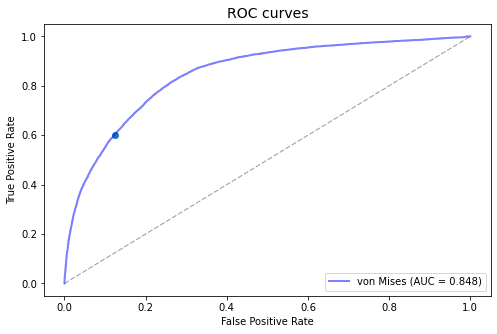

In [28]:
plt.figure(figsize=(8,5))
plt.plot([0, 1], [0, 1], linestyle='--', dashes=(5, 2), linewidth=1, color=[0.6, 0.6, 0.6])
plt.plot(fpr_vonMises, tpr_vonMises, 'b', linewidth=2, alpha = 0.5, label='von Mises (AUC = %0.3f)' % AUC_vonMises)

# YOUR CODE HERE

# SOLUTION
FPR = FP/(FP+TN)
plt.scatter(FPR, TPR)


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves', size = 14)
plt.legend(loc="lower right");

_YOUR ANSWER HERE_

The logistic regression provides a classification for threshold $p = 0.5$ while the other points of the ROC curve are for any threshold from 0 to 1.

### 2.4. Feature engineering

Mignan & Broccardo (2019) showed that there was no need to compute stress and use them as features to predict aftershocks in space. They defined instead a logistic regression model with two simpler features: minimum distance to the mainshock rupture & mainshop mean slip.

**EXERCISE 9:** Define minimum distance `dmin` and `slip` as new features. You need to use the SRCMOD data (provided on BlackBoard) and the $(x,y,z)$ coordinates given in `data_df`. While you can find the solution by yourself, another approach often useful is to try to find out if a similar work has already been done. Like a machine learning detective, you might want to dig into the lecturer's github https://github.com/amignan (part of the solution is there, somewhere...). Note that it will take a couple of minutes to run.

First let us load the SRCMOD data which gives the geometry and slip of the faults rupturing during each mainshock.

In [29]:
# mainshock rupture data
SRCMOD = pd.read_csv(os.path.join(os.path.dirname(notebook_path), "data/aftershocks/SRCMOD_simplified.csv"))
SRCMOD.head()

,Unnamed: 0,ID,x,y,z,slipMean
0,0,s1968HYUGAx01YAGI,302275.167050,3.575726e+06,-11255.6,1.318214
1,1,s1968HYUGAx01YAGI,295549.514204,3.569726e+06,-11255.6,1.318214
2,2,s1968HYUGAx01YAGI,288816.128267,3.563741e+06,-11255.6,1.318214
3,3,s1968HYUGAx01YAGI,282084.001384,3.557748e+06,-11255.6,1.318214
4,4,s1968HYUGAx01YAGI,275334.750771,3.551771e+06,-11255.6,1.318214


In [30]:
# YOUR CODE HERE
dmin = []
slip = []

#for i in range(?):
#    if i%1e4 == 0: print(i)
#    x_cell = data_xyz_balanced['x'].iloc[i]
#    y_cell = data_xyz_balanced['y'].iloc[i]
#    z_cell = data_xyz_balanced['z'].iloc[i]
#    ID_cell = data_xyz_balanced['ID'].iloc[i]
    
#    SRCMODi = SRCMOD.loc[lambda SRCMOD: SRCMOD['ID'] == ID_cell, :]
    
    # do feature engineering
#    ...
#    ...
#    ...  
#    ...
#    dmin.append(?)
#    slip.append(?)



# SOLUTION
for i in range(len(data_xyz_balanced)):
    if i%1e4 == 0: print(i)
    x_cell = data_xyz_balanced['x'].iloc[i]
    y_cell = data_xyz_balanced['y'].iloc[i]
    z_cell = data_xyz_balanced['z'].iloc[i]
    ID_cell = data_xyz_balanced['ID'].iloc[i]
    
    SRCMODi = SRCMOD.loc[lambda SRCMOD: SRCMOD['ID'] == ID_cell, :]
    
    # do feature engineering
    x_flt = SRCMODi['x']
    y_flt = SRCMODi['y']
    z_flt = SRCMODi['z']
    
    dist2cell = np.sqrt(np.power((x_flt - x_cell), 2) + 
                                np.power((y_flt - y_cell), 2) + 
                                np.power((z_flt - z_cell), 2))
    dmin.append(min(dist2cell))
    slip.append(SRCMODi['slipMean'].iloc[0])

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000


In [31]:
# redo filtering, split
data_xyz_wNewFeatures = data_xyz_balanced
data_xyz_wNewFeatures['dmin'] = dmin
data_xyz_wNewFeatures['slip'] = slip

TrainingSet2 = data_xyz_wNewFeatures.loc[data_xyz_wNewFeatures['ID'].isin(training_IDs)]
TestingSet2 = data_xyz_wNewFeatures.loc[data_xyz_wNewFeatures['ID'].isin(testing_IDs)]

**EXERCISE 10:** Run a new logistic regression model with `dmin` and `slip` as features. Write down the new equation in latex format. As with the von Mises criterion, we will use the natural logarithm of the features.

In [32]:
# YOUR CODE HERE
#x_train2 = ?
#y_train2 = ?

#logreg_model2 = ?
#...

#x_test2 = ?
#y_test2_true = ?

#y_pred2 = ?
#y_pred2_pr = ?


# SOLUTION
x_train2 = np.log(TrainingSet2[['dmin', 'slip']])
y_train2 = TrainingSet2['aftershocksyn']

logreg_model2 = LogisticRegression()
logreg_model2.fit(x_train2, y_train2)

x_test2 = np.log(TestingSet2[['dmin', 'slip']])
y_test2_true = TestingSet2['aftershocksyn']

y_pred2 = logreg_model2.predict(x_test2)
y_pred2_pr = logreg_model2.predict_proba(x_test2)[:, 1]



print(logreg_model2.coef_, logreg_model2.intercept_)

[[-1.00799056  0.50180396]] [10.26475705]


_YOUR ANSWER HERE_
$$
...
$$


SOLUTION
$$
P(y) = \frac{1}{1 + e^{-(10.29 - 1.01 \ln d_{min} + 0.50 \ln s_{mean})}}
$$

**EXERCISE 11:** Find the model parameters obtained by Mignan & Broccardo (2019) in their article. They differ with your finding. Can you find any reason why? Rerun the previous cell by updating one line to verify if your resaoning was correct. _Hint: we used the natural logarithm here_

_YOUR ANSWER HERE_

SOLUTION
We here used the natural logarithm while the paper uses the log10, hence a shift in the parameters.

**EXERCISE 12:** Calculate the new ROC curve and plot it in red on top of the von Mises model (in blue). Compare the 2 models in words to conclude this application.

AUC of logistic regression with geometric feature: 0.862182547791674


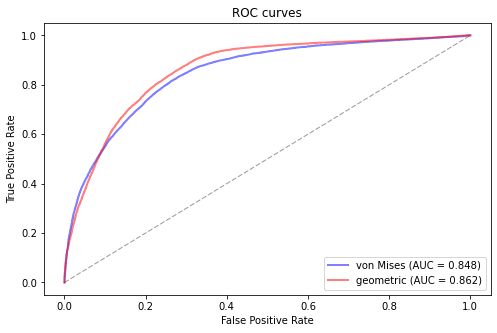

In [33]:
# YOUR CODE HERE
#...
#AUC_geom = auc(fpr_geom, tpr_geom)

#plt.figure(figsize=(8,5))
#... several lines of code


# SOLUTION
fpr_geom, tpr_geom, _ = roc_curve(y_test2_true, y_pred2_pr)
AUC_geom = auc(fpr_geom, tpr_geom)

plt.figure(figsize=(8,5))
plt.plot([0, 1], [0, 1], linestyle='--', dashes=(5, 2), linewidth=1, color=[0.6, 0.6, 0.6])
plt.plot(fpr_vonMises, tpr_vonMises, 'b', linewidth=2, alpha = 0.5, label='von Mises (AUC = %0.3f)' % AUC_vonMises)
plt.plot(fpr_geom, tpr_geom, 'r', linewidth=2, alpha = 0.5, label='geometric (AUC = %0.3f)' % AUC_geom)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc='lower right');


print('AUC of logistic regression with geometric feature:', AUC_geom)

_YOUR ANSWER HERE_

SOLUTION
The geometric model is slightly better than the stress model, because of the higher AUC. We see the red curve above the blue curve for most of the ROC space.

## 3. References

* DeVries et al. (2018), Deep learning of aftershock patterns following large earthquakes, Nature, 560, 632-634
* Mignan & Broccardo (2019), One neuron versus deep learning in aftershock prediction, Nature, 574, E1-E3